In [1]:
import os
# Отключает все логи TensorFlow (0 - все, 1 - предупреждения, 2 - ошибки, 3 - критичные ошибки)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [64]:
from sklearn import datasets
import pandas as pd
import numpy as np
from typing import List, Union
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
import pandas as pd
from sklearn.inspection import permutation_importance
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

# Загружаем наш датасет и проверяем его

In [3]:
df = pd.read_csv('content/train.csv')

In [4]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [53]:
# Кодируем категориальные переменные (Label Encoding)
categorical_columns = df.select_dtypes(include=['object']).columns
df_encoded = df.copy()

for col in categorical_columns:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])

# Убираем целевую переменную из X
X = df_encoded.drop(columns=['Survived'])
X = X.dropna()
X_scaler = StandardScaler().fit_transform(X)

In [54]:
X

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,108,1,22.0,1,0,523,7.2500,147,2
1,2,1,190,0,38.0,1,0,596,71.2833,81,0
2,3,3,353,0,26.0,0,0,669,7.9250,147,2
3,4,1,272,0,35.0,1,0,49,53.1000,55,2
4,5,3,15,1,35.0,0,0,472,8.0500,147,2
...,...,...,...,...,...,...,...,...,...,...,...
885,886,3,684,0,39.0,0,5,480,29.1250,147,1
886,887,2,548,1,27.0,0,0,101,13.0000,147,2
887,888,1,303,0,19.0,0,0,14,30.0000,30,2
889,890,1,81,1,26.0,0,0,8,30.0000,60,0


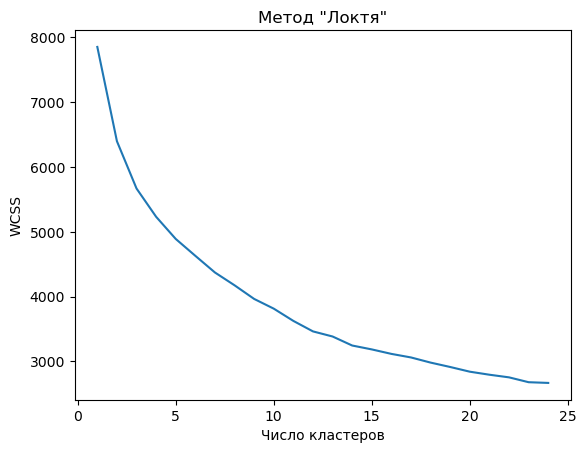

In [74]:
import warnings
warnings.filterwarnings('ignore')
wcss = []
t_max = 25

# Применим k-средних для k от 1 до 15
for i in range(1, t_max):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_scaler)
    wcss.append(kmeans.inertia_)
# Визуализация результатов

plt.plot(range(1, t_max), wcss)
plt.title('Метод "Локтя"')
plt.xlabel('Число кластеров')
plt.ylabel('WCSS')
plt.show()

Исходя из графика выбираем K=12

In [51]:
K=12

In [56]:
kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaler) 

X = pd.DataFrame(X_scaler, columns=X.columns)  # возвращаем DataFrame
X["Cluster"] = clusters  # добавляем колонку кластеров


In [57]:
X

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cluster
0,-1.728532,0.911232,-1.192187,0.759051,-0.530377,0.524570,-0.505895,0.922675,-0.518978,0.485988,0.512924,7
1,-1.724670,-1.476364,-0.881388,-1.317434,0.571831,0.524570,-0.505895,1.281724,0.691897,-1.272974,-2.048108,2
2,-1.720808,0.911232,-0.263580,-1.317434,-0.254825,-0.551703,-0.505895,1.640772,-0.506214,0.485988,0.512924,11
3,-1.716946,-1.476364,-0.570589,-1.317434,0.365167,0.524570,-0.505895,-1.408681,0.348049,-1.965898,0.512924,6
4,-1.713084,0.911232,-1.544678,0.759051,0.365167,-0.551703,-0.505895,0.671833,-0.503850,0.485988,0.512924,7
...,...,...,...,...,...,...,...,...,...,...,...,...
709,1.689274,0.911232,0.990986,-1.317434,0.640719,-0.551703,5.357890,0.711181,-0.105320,0.485988,-0.767592,1
710,1.693136,-0.282566,0.475515,0.759051,-0.185937,-0.551703,-0.505895,-1.152920,-0.410245,0.485988,0.512924,0
711,1.696998,-1.476364,-0.453092,-1.317434,-0.737041,-0.551703,-0.505895,-1.580828,-0.088774,-2.632171,0.512924,6
712,1.704722,-1.476364,-1.294523,0.759051,-0.254825,-0.551703,-0.505895,-1.610338,-0.088774,-1.832643,-2.048108,2


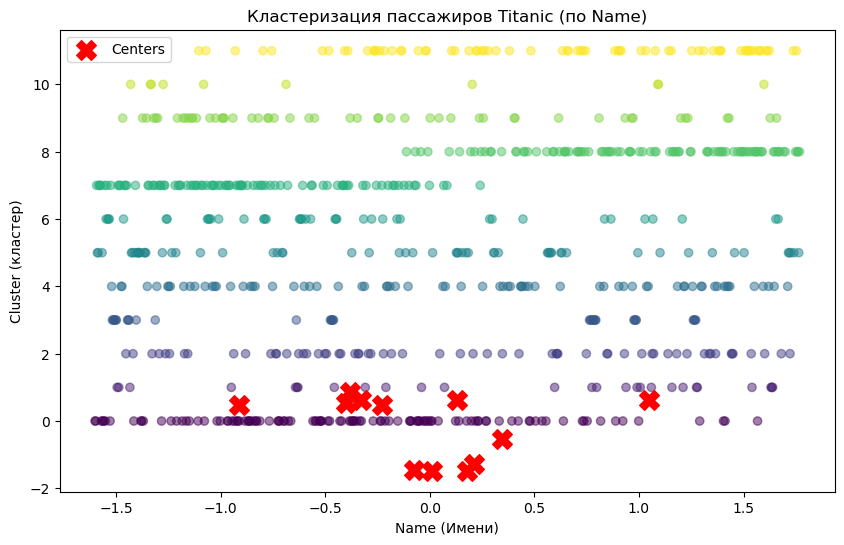

In [58]:
plt.figure(figsize=(10, 6))
plt.scatter(X["Name"], X["Cluster"], c=X["Cluster"], cmap="viridis", alpha=0.5)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c="red", marker="X", s=200, label="Centers")

plt.xlabel("Name (Имени)")
plt.ylabel("Cluster (кластер)")
plt.legend()
plt.title("Кластеризация пассажиров Titanic (по Name)")
plt.show()

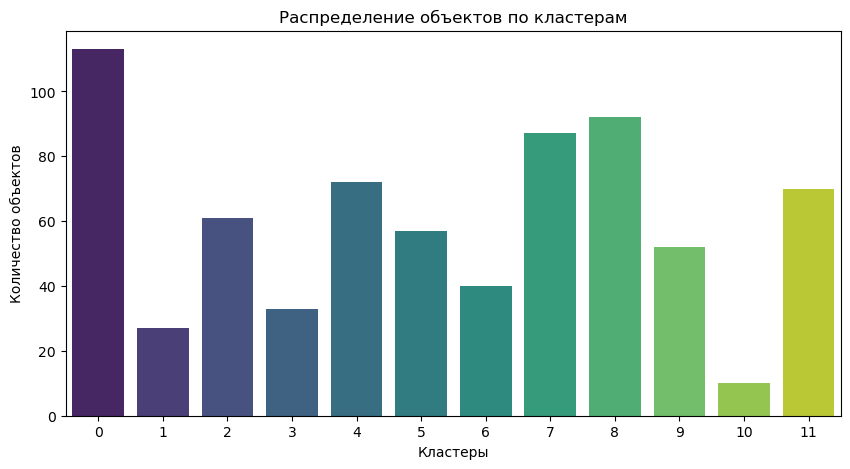

In [59]:
unique, counts = np.unique(clusters, return_counts=True)

plt.figure(figsize=(10, 5))
sns.barplot(x=unique, y=counts, palette="viridis")

plt.xlabel("Кластеры")
plt.ylabel("Количество объектов")
plt.title("Распределение объектов по кластерам")
plt.xticks(unique)
plt.show()

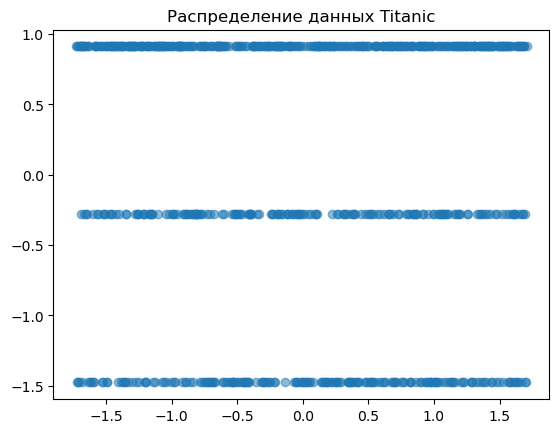

In [60]:
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], alpha=0.5)
plt.title("Распределение данных Titanic")
plt.show()

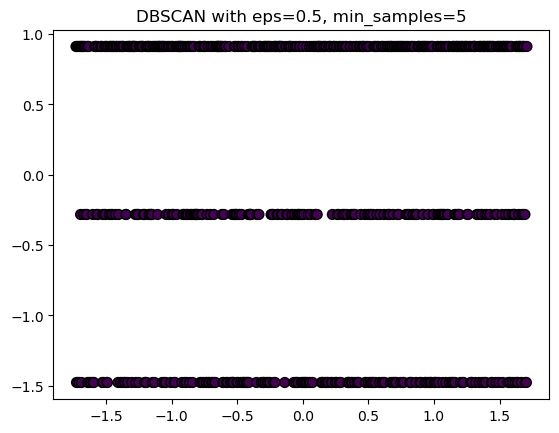

In [61]:
dbscan = DBSCAN(eps=0.001, min_samples=6)
clusters_dbscan = dbscan.fit_predict(X_scaler)


plt.scatter(X_scaler[:, 0], X_scaler[:, 1], c=clusters_dbscan, cmap="viridis", marker='o', edgecolor='black', s=50)
plt.title('DBSCAN with eps=0.5, min_samples=5')
plt.show()

In [39]:
def display_clusters(model,eps,min_samples):


   plt.scatter(X_scaler[:, 0], X_scaler[:, 1], c=clusters, cmap="viridis", marker='o', edgecolor='black', s=50)
   plt.title(f'DBSCAN with eps={eps}, min_samples={min_samples}')
   print(f'Кластерные метки: {np.unique(dbscan.labels_)}')
   print(f'Количество выбросов: {np.sum(dbscan.labels_==-1)}')
   plt.show()

Кластерные метки: [-1  0  1]
Количество выбросов: 710


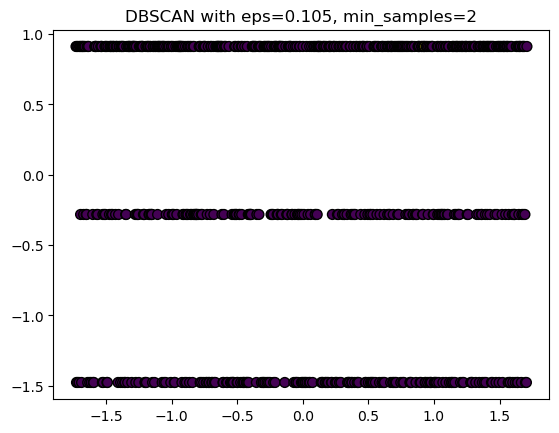

In [73]:
eps=0.105
min_samples=2
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
clusters = dbscan.fit_predict(X_scaler)
display_clusters(clusters,eps,min_samples)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:41<00:00,  1.64s/it]


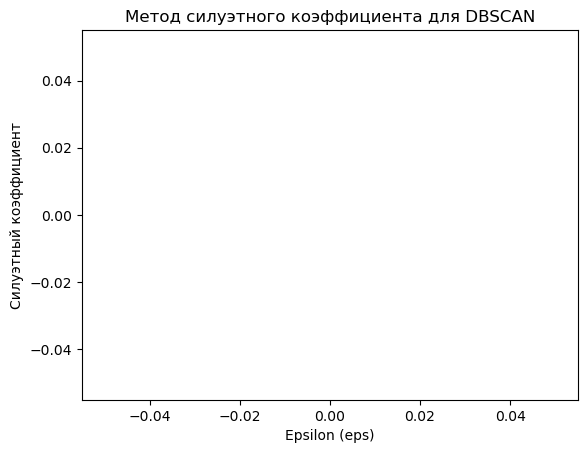

Лучшие параметры: {}


In [68]:
silhouette_coefficients = {}

best_score = -1  # Инициализация для лучшего коэффициента силуэта
best_params = {}

# Запуск по диапазону
for j in tqdm(range(5, 30)):
    for k in range(5, 300, 1):
        epsilon = k / 1000  # Преобразуем значение в eps
        dbscan = DBSCAN(eps=epsilon, min_samples=j)
        clusters = dbscan.fit_predict(X_scaler)

        try:
            # Вычисляем силуэтный коэффициент
            score = silhouette_score(X_scaler, clusters)
            silhouette_coefficients[epsilon] = score
        except:
            continue

        # Если текущий коэффициент лучше, сохраняем параметры
        if score > best_score:
            best_score = score
            best_params = {'epsilon': epsilon, 'min_samples': j, 'score': score}

# Визуализация результатов
epsilons = list(silhouette_coefficients.keys())  # Получаем все epsilon значения
scores = list(silhouette_coefficients.values())  # Получаем силуэтные коэффициенты

plt.plot(epsilons, scores, marker='o')
plt.title('Метод силуэтного коэффициента для DBSCAN')
plt.xlabel('Epsilon (eps)')
plt.ylabel('Силуэтный коэффициент')
plt.show()

# Вывод лучших параметров
print(f'Лучшие параметры: {best_params}')